# 1️⃣ Token-Level Metrics

| Metric                    | Açıklama                                                                                                                         |
| ------------------------- | -------------------------------------------------------------------------------------------------------------------------------- |
| **Token Accuracy**        | Her token için doğru tahmin yüzdesi. Seq2Seq ve LLM’lerde padding tokenleri hariç hesaplanır.                                    |
| **Perplexity (PPL)**      | Loss’un anlamlı bir ölçüye çevrilmiş hâli: `PPL = exp(loss)`. Düşük perplexity → modelin daha iyi tahmin yaptığı anlamına gelir. |
| **Masked Token Accuracy** | Sadece maskelenmiş veya ilgi duyulan tokenler üzerinden doğruluk (ör. MLM görevlerinde).                                         |


# 2️⃣ Sequence-Level Metrics

| Metric                         | Açıklama                                                                                         |
| ------------------------------ | ------------------------------------------------------------------------------------------------ |
| **BLEU**                       | Seq2Seq çeviri veya text generation görevlerinde referans cümle ile model çıktısının benzerliği. |
| **ROUGE**                      | Özellikle özetleme ve text generation’da n-gram overlap ölçer.                                   |
| **METEOR / CIDEr / BERTScore** | Daha gelişmiş metrikler; n-gram ve semantic benzerliği ölçer.                                    |


# 3️⃣ Diğer Özel Metrics

| Metric                      | Açıklama                                                                                       |
| --------------------------- | ---------------------------------------------------------------------------------------------- |
| **Loss / CrossEntropy**     | Token-level kayıp (eğitim sırasında ölçülür).                                                  |
| **Accuracy@k**              | Top-k tahminler içinde doğru token var mı diye bakar (LLM’lerde top-5/top-10 için kullanılır). |
| **F1 / Precision / Recall** | Nadir token veya sınıflandırma görevlerinde token bazlı F1.                                    |


### ⚡ Notlar:

* Training sırasında genellikle: Token-level loss ve perplexity kullanılır.

* Validation veya generation sırasında: BLEU, ROUGE gibi sequence-level metrics daha anlamlıdır.

* Karma metrics: Token accuracy + perplexity + top-k accuracy ile modelin hem dilsel hem de probabilistik performansı ölçülebilir.

In [ ]:
import torch
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup

# -----------------------
# Model Tanımı (Örnek)
# -----------------------
model = MySeq2SeqModel(vocab_size=30522, d_model=512)

# -----------------------
# Optimizer
# -----------------------
optimizer = AdamW(
    model.parameters(),
    lr=5e-5,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0.01
)

# -----------------------
# Loss Fonksiyonu
# -----------------------
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# -----------------------
# Scheduler (Opsiyonel)
# -----------------------
num_training_steps = 10000
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=500,
    num_training_steps=num_training_steps
)

# -----------------------
# Metrics Fonksiyonları
# -----------------------
def token_accuracy(pred, target, pad_token_id):
    """Padding tokenlerini ignore ederek token-level accuracy hesaplar."""
    pred_ids = pred.argmax(dim=-1)
    mask = target != pad_token_id
    correct = (pred_ids == target) & mask
    return correct.sum().float() / mask.sum()

def perplexity(loss):
    """Token-level perplexity hesaplar."""
    return torch.exp(loss)

# -----------------------
# Training Step
# -----------------------
def train_step(input_ids, target_ids):
    model.train()
    optimizer.zero_grad()

    outputs = model(input_ids, labels=target_ids)

    # Loss hesaplama
    loss = criterion(
        outputs.logits.view(-1, outputs.logits.size(-1)),
        target_ids.view(-1)
    )

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()  # opsiyonel

    # Metrics
    acc = token_accuracy(outputs.logits, target_ids, tokenizer.pad_token_id)
    ppl = perplexity(loss)

    return loss.item(), acc.item(), ppl.item()

# -----------------------
# Örnek Kullanım
# -----------------------
# loss, accuracy, ppl = train_step(batch_input_ids, batch_target_ids)


## ⚡ Açıklamalar:

* Optimizer: AdamW kullanıldı, LLM’lerde standart.

* Loss: nn.CrossEntropyLoss ile padding tokenleri ignore ediliyor.

* Scheduler: Learning rate warmup + linear decay.

Metrics:

* token_accuracy: Padding tokenleri ignore ederek token-level doğruluk.

* perplexity: Loss’tan elde edilen anlamlı ölçüm.

* Train Step: Compile mantığını PyTorch tarzında uyguluyor; eğitim sırasında loss ve metrics hesaplanıyor.

----
# Şimdi PyTorch ile LLM’ler için full pipeline oluşturuyoruz: eğitim + validation + token-level ve sequence-level metrics (BLEU/ROUGE). Bu yapı, modelinizi hem eğitim hem de generation sırasında performans ölçümü için hazır hâle getirir.
---


In [ ]:
import torch
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup
from datasets import load_metric

# -----------------------
# Model Tanımı (Örnek)
# -----------------------
model = MySeq2SeqModel(vocab_size=30522, d_model=512)

# -----------------------
# Optimizer & Scheduler
# -----------------------
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
num_training_steps = 10000
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=num_training_steps)

# -----------------------
# Loss Fonksiyonu
# -----------------------
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# -----------------------
# Token-level Metrics
# -----------------------
def token_accuracy(pred, target, pad_token_id):
    pred_ids = pred.argmax(dim=-1)
    mask = target != pad_token_id
    correct = (pred_ids == target) & mask
    return correct.sum().float() / mask.sum()

def perplexity(loss):
    return torch.exp(loss)

# -----------------------
# Sequence-level Metrics
# -----------------------
bleu_metric = load_metric("bleu")
rouge_metric = load_metric("rouge")

def compute_sequence_metrics(pred_sequences, target_sequences):
    # BLEU expects list of references and list of predictions
    bleu_score = bleu_metric.compute(predictions=pred_sequences, references=[[t] for t in target_sequences])
    rouge_score = rouge_metric.compute(predictions=pred_sequences, references=target_sequences)
    return bleu_score, rouge_score

# -----------------------
# Train Step
# -----------------------
def train_step(input_ids, target_ids):
    model.train()
    optimizer.zero_grad()
    outputs = model(input_ids, labels=target_ids)
    loss = criterion(outputs.logits.view(-1, outputs.logits.size(-1)), target_ids.view(-1))
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    acc = token_accuracy(outputs.logits, target_ids, tokenizer.pad_token_id)
    ppl = perplexity(loss)
    return loss.item(), acc.item(), ppl.item()

# -----------------------
# Validation Step
# -----------------------
def validate_step(val_input_ids, val_target_ids, tokenizer):
    model.eval()
    with torch.no_grad():
        outputs = model.generate(val_input_ids, max_length=50)
        # Decode tokens to strings
        pred_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs]
        target_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in val_target_ids]

        # Token-level loss & metrics
        logits = model(val_input_ids, labels=val_target_ids).logits
        loss = criterion(logits.view(-1, logits.size(-1)), val_target_ids.view(-1))
        acc = token_accuracy(logits, val_target_ids, tokenizer.pad_token_id)
        ppl = perplexity(loss)

        # Sequence-level metrics
        bleu, rouge = compute_sequence_metrics(pred_texts, target_texts)

    return {
        "loss": loss.item(),
        "token_acc": acc.item(),
        "perplexity": ppl.item(),
        "bleu": bleu,
        "rouge": rouge
    }

# -----------------------
# Örnek Kullanım
# -----------------------
# train_loss, train_acc, train_ppl = train_step(batch_input_ids, batch_target_ids)
# val_metrics = validate_step(val_input_ids, val_target_ids, tokenizer)


## ⚡ Açıklamalar:

* Train Step: Token-level loss, token_accuracy ve perplexity hesaplıyor.

#### **Validation Step:**

* generate ile sequence üretip BLEU ve ROUGE hesaplıyor.

* Token-level loss ve metrics de alınıyor.

#### **Metrics:**

* Token-level: accuracy, perplexity

* Sequence-level: BLEU, ROUGE (text generation için)

#### **Compile mantığı:**

* Optimizer + Loss + Scheduler + Metrics → hazır pipeline

Bu yapı, LLM’ler için tipik train + validation pipeline ve Keras’daki compile/fit mantığına eşdeğer bir şekilde çalışır.

----
# LLM’lerde yaygın olarak kullanılan metrics’ler ve bu metrics’lerde hangi değerlerin daha iyi olduğunu net bir tabloyla özetleyelim:
---

| Metric                         | Ne Ölçer?                                                             | Daha İyi Değer | Açıklama                                                                  |
| ------------------------------ | --------------------------------------------------------------------- | -------------- | ------------------------------------------------------------------------- |
| **Loss (CrossEntropy)**        | Modelin token-level tahmin hatası                                     | **Düşük**      | Düşük loss → modelin tokenleri doğru tahmin etme oranı yüksek             |
| **Perplexity (PPL)**           | Modelin tahmin belirsizliği (loss’tan türetilir)                      | **Düşük**      | Düşük perplexity → modelin dili daha iyi öğrendiği anlamına gelir         |
| **Token Accuracy**             | Padding hariç her tokenin doğru tahmin oranı                          | **Yüksek**     | %100’e yakın → modelin tokenleri doğru tahmin etme başarısı yüksek        |
| **Top-k Accuracy**             | Top-k tahminler arasında doğru tokenin bulunma oranı                  | **Yüksek**     | Örneğin top-5 accuracy %95 → doğru token 5 tahminden birinde var          |
| **BLEU**                       | N-gram overlap ile üretilen sequence ve referans arasındaki benzerlik | **Yüksek**     | 0-1 veya 0-100 ölçeğinde, yüksek → daha yakın match                       |
| **ROUGE**                      | N-gram, LCS (longest common subsequence) ile metin benzerliği         | **Yüksek**     | 0-1 veya 0-100 ölçeğinde, yüksek → özetleme veya generation doğruluğu iyi |
| **METEOR / CIDEr / BERTScore** | Semantic ve n-gram benzerliği                                         | **Yüksek**     | Yüksek → üretilen text referansa daha anlamlı yakın                       |
| **F1 Score (Token/Class)**     | Precision + Recall dengesi                                            | **Yüksek**     | 0-1 arası, yüksek → doğru ve dengeli token tahmini                        |


### ⚡ Özet Mantık

* Düşük olanlar: Loss, Perplexity → ne kadar düşükse model o kadar iyi.

* Yüksek olanlar: Token Accuracy, Top-k Accuracy, BLEU, ROUGE, METEOR, F1 → ne kadar yüksekse model o kadar başarılı.

* Pratikte eğitim sırasında loss ve perplexity düşürülmeye çalışılır, token-level ve sequence-level metrics ise validation ve generation performansını izlemek için yüksek tutulur.

---
# O zaman PyTorch ve Matplotlib / Seaborn kullanarak, eğitim sırasında metrics’leri takip etmek ve görselleştirmek için bir örnek hazırlayalım. Bu sayede loss, perplexity ve token/sequence-level metrics’i canlı grafiklerle izleyebiliriz.
---

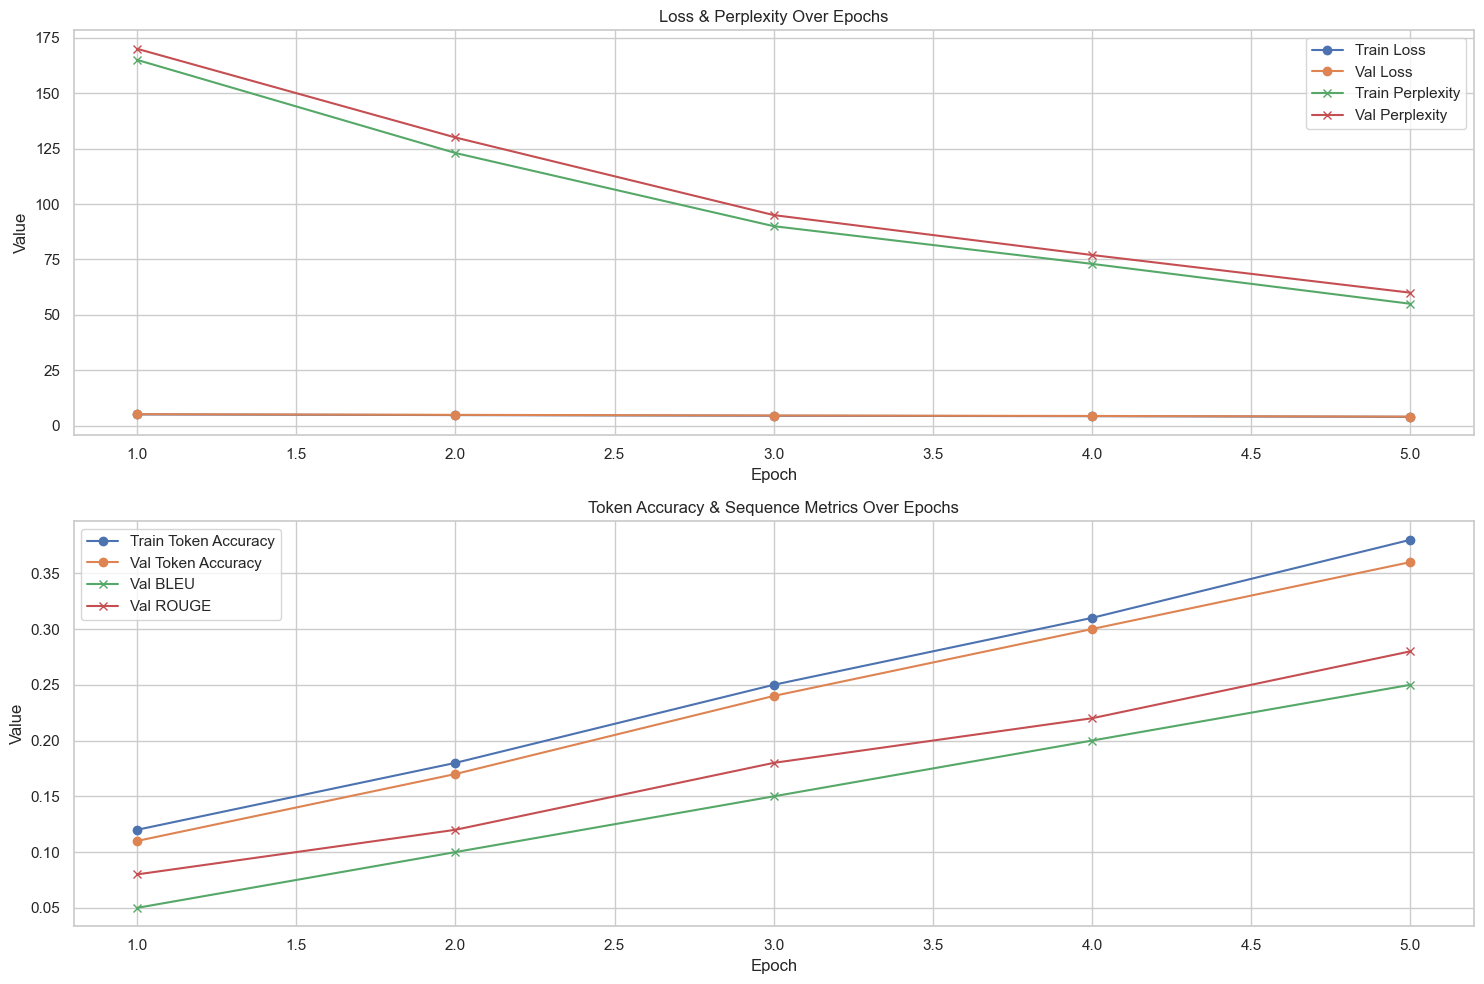

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------
# Örnek data (train & validation metrics)
# -----------------------
history = {
    "train_loss": [5.1, 4.8, 4.5, 4.3, 4.0],
    "val_loss": [5.2, 4.9, 4.6, 4.4, 4.1],
    "train_ppl": [165, 123, 90, 73, 55],
    "val_ppl": [170, 130, 95, 77, 60],
    "train_acc": [0.12, 0.18, 0.25, 0.31, 0.38],
    "val_acc": [0.11, 0.17, 0.24, 0.30, 0.36],
    "val_bleu": [0.05, 0.10, 0.15, 0.20, 0.25],
    "val_rouge": [0.08, 0.12, 0.18, 0.22, 0.28]
}

epochs = range(1, len(history["train_loss"]) + 1)

sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# -----------------------
# Loss & Perplexity
# -----------------------
plt.subplot(2, 1, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss", marker='o')
plt.plot(epochs, history["val_loss"], label="Val Loss", marker='o')
plt.plot(epochs, history["train_ppl"], label="Train Perplexity", marker='x')
plt.plot(epochs, history["val_ppl"], label="Val Perplexity", marker='x')
plt.title("Loss & Perplexity Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()

# -----------------------
# Accuracy & Sequence Metrics
# -----------------------
plt.subplot(2, 1, 2)
plt.plot(epochs, history["train_acc"], label="Train Token Accuracy", marker='o')
plt.plot(epochs, history["val_acc"], label="Val Token Accuracy", marker='o')
plt.plot(epochs, history["val_bleu"], label="Val BLEU", marker='x')
plt.plot(epochs, history["val_rouge"], label="Val ROUGE", marker='x')
plt.title("Token Accuracy & Sequence Metrics Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()

plt.tight_layout()
plt.show()


## ⚡ Açıklamalar

### **İki subplot:**

* İlk grafik → Loss ve Perplexity (düşmesi iyi)

* İkinci grafik → Token Accuracy ve Sequence Metrics (yükselmesi iyi)

* Marker kullanımı: Farklı metrics’leri ayırt etmek için o ve x kullandık.

* Seaborn + Matplotlib: Estetik ve okunabilir grafikler için ideal.

Bu pipeline ile eğitim sırasında tüm önemli metrics’leri canlı olarak görselleştirebilir ve hangi değerlerin iyi olduğunu kolayca takip edebilirsin.